### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

### Loading the unlabelled dataset and convering it into numpy array of length $64 \times 64 = 4096$

In [2]:
def load_lfw_dataset(lfw_path):
    image_paths = glob.glob(os.path.join(lfw_path, '*', "*.jpg"))
    images = []
    print(f"Found {len(image_paths)} images in the dataset.")

    for image_path in image_paths:
        try:
            img = Image.open(image_path).convert('L')
            img = img.resize((64,64))
            img_array = np.array(img).flatten()
            images.append(img_array)

        except:
            continue
    
    return np.array(images)

### Scaling the data

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

lfw_path = 'dataset\lfw-deepfunneled'

lfw_images = load_lfw_dataset(lfw_path)
print(f"Loaded {lfw_images.shape[0]} images with shape {lfw_images.shape[1]}.")
scaler = StandardScaler()
lfw_images_scaled = scaler.fit_transform(lfw_images)


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\RONIT\AppData\Local\Temp\ipykernel_17432\500802564.py:4: SyntaxWarning: invalid escape sequence '\l'
  lfw_path = 'dataset\lfw-deepfunneled'


Found 13076 images in the dataset.
Loaded 13076 images with shape 4096.


### Finding a nice value of $k$ using Explained variance

Explained variance for 5 components: 0.4289
Explained variance for 10 components: 0.5506
Explained variance for 15 components: 0.6204
Explained variance for 20 components: 0.6630
Explained variance for 25 components: 0.6935
Explained variance for 30 components: 0.7174
Explained variance for 35 components: 0.7366
Explained variance for 40 components: 0.7531
Explained variance for 45 components: 0.7677
Explained variance for 50 components: 0.7803
Explained variance for 55 components: 0.7913
Explained variance for 60 components: 0.8008
Explained variance for 65 components: 0.8095
Explained variance for 70 components: 0.8175
Explained variance for 75 components: 0.8246
Explained variance for 80 components: 0.8312
Explained variance for 85 components: 0.8373
Explained variance for 90 components: 0.8429
Explained variance for 95 components: 0.8480
Explained variance for 100 components: 0.8529
Explained variance for 105 components: 0.8573
Explained variance for 110 components: 0.8616
Explaine

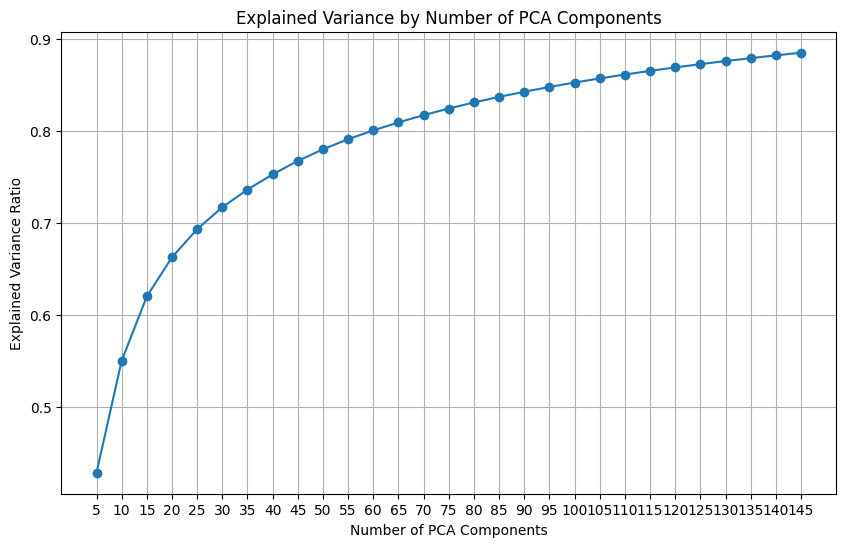

In [4]:
k_values = list(range(5  , 150,5))
explained_variances = []
for k in k_values:
    pca = PCA(n_components=k)
    pca.fit(lfw_images_scaled)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))
    print(f"Explained variance for {k} components: {explained_variances[-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(k_values, explained_variances, marker='o')
plt.title('Explained Variance by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(k_values)
plt.grid()
plt.show()

### Choosing $k=100$ and applying PCA to unlabelled data

In [5]:
pca = PCA(n_components=100)
lfw_pca = pca.fit_transform(lfw_images_scaled)
print(f"Reduced to {lfw_pca.shape[1]} PCA components.")

Reduced to 100 PCA components.


### Loading the labelled dataset (removed less represented emotions)

In [6]:
df = pd.read_csv('dataset/labelled.csv')
df = df[~df['emotion'].isin([2,4,7])]
df.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


### Splitting into Train and test data and applying PCA to it

In [7]:
def parse_pixels(pixel_str):
    return np.array([int(x) for x in pixel_str.split()], dtype=np.uint8)

X = np.stack(df['pixels'].apply(parse_pixels).values)
y = df['emotion'].astype(int).values
usage = df['Usage'].values

X_train = X[usage == 'Training']
y_train = y[usage == 'Training']
test_mask = (usage == 'PublicTest') | (usage == 'PrivateTest')
X_test = X[test_mask]
y_test = y[test_mask]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

###  Using SVM to train the final model and get its classification report, accuracy and confusion matrix

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

svm = SVC(kernel='linear', C = 1, gamma= 'scale')
svm.fit(X_train_pca, y_train)

y_pred = svm.predict(X_test_pca)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       1.00      0.67      0.80        12
           3       1.00      0.93      0.96        14
           5       0.84      0.94      0.89        17
           6       0.92      0.96      0.94       119

    accuracy                           0.90       171
   macro avg       0.84      0.77      0.79       171
weighted avg       0.90      0.90      0.90       171

Confusion Matrix:
[[  3   0   0   0   6]
 [  1   8   0   0   3]
 [  0   0  13   1   0]
 [  0   0   0  16   1]
 [  3   0   0   2 114]]
Accuracy: 90.06%
